In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from perlin_numpy import (
    generate_perlin_noise_2d, generate_fractal_noise_2d
)
from matplotlib import animation
import webcolors



In [8]:
def magnitude(X, n, a):

    if a >= 0:

        # I used to know how this worked, but I used a graph to figure it out
        reg = {(1, 0): abs(a), (1, 1): abs(a-45), (0, 1): abs(a-90),
               (-1, 1): abs(a-135), (-1, 0): abs(180-a), (-1, -1): abs(180-abs(a-45)),
               (0, -1): abs(180-abs(a-90)), (1, -1): abs(180-abs(a-135))}

        d = n**(-(reg[X]/90)+1)

    if a <= 0:

        a = -a

        # even more confused about this one

        reg = {(1, 0): abs(a), (1, 1): abs(180-abs(a-135)), (0, 1): abs(180-abs(a-90)),
               (-1, 1): abs(180-abs(a-45)), (-1, 0): abs(180-a),
               (-1, -1): abs(a-135), (0, -1): abs(a-90), (1, -1): abs(a-45)}

        d = n**(-(reg[X]/90)+1)
    return d

##
#--- 
#--- Steps: 1. Distribute fuel evenly among 8 vectors in the cardinal directions (N, NE, etc.)
#---        2. Calculate vectors for the diagonal ones (pythag theorem)
#---        3. Calculate the magnitude and then set a constant to be equal to all the factor used
#---             4. These factors include: forest weight at the value of where it will spread, the magnitude, and the evenly distributed fuel.
#---        5. Multiply each aspect of the list by its respective constant
#
def calculate_vectors(tup, forest, wind_direction, wind_strength):
    region = [(1, 0), (1, 1), (0, 1), (-1, 1),
              (-1, 0), (-1, -1), (0, -1), (1, -1)]
    x = tup[0]
    y = tup[1]
  # divide fire fuel by 8 to evenly divide fuel among vectors
    n = forest[x, y]/8

    # find x and y values for diagonal vectors
    a = np.sqrt(2)*n/2

    # index 0 corresponds to first vector, look at drawings
    vectors = [[n, 0], [a, a], [0, n], [-a, a],
               [-n, 0], [-a, -a], [0, -n], [a, -a]]

    # for loop uses p,q and i as double-data storage
    for p, q in region:

        # all factors used:
        mag = wind_strength[x, y]  # wind_strength[x,y]

        c = n*forest[x+p, y+q]*magnitude((p, q), mag, wind_direction[x, y])

        i = region.index((p, q))

        # x value times change coefficient
        vectors[i][0] *= c

        # y value times change coefficient
        vectors[i][1] *= c

    return vectors


def initialize_grid(size):
    forest = generate_perlin_noise_2d(
        (size, size), (2, 2), (True, True))  # discrete

   # forest = np.zeros((size,size), dtype = float)  #discrete
   # elev_map = generate_perlin_noise_2d((size, size),(2,2),(True,True))
    # humidity
    wind_direction = np.zeros((size, size), dtype=float)
   # wind_direction = generate_perlin_noise_2d(
    # (size, size), (2, 2), (True, True))
    wind_strength = np.zeros((size, size), dtype=float)

    for x in range(0, size):
        for y in range(0, size):
            forest[x, y] += 2
            forest[x, y] *= (1/2)
            forest[x, y] *= 4.5
            wind_direction[x, y] += 45
            wind_strength[x, y] += 1.5

    return forest, wind_direction, wind_strength

##----Directional Movement function is my new calculation function. it takes in the already exsisting fireLst, and all the arrays, 
#and calculates where all the points have to move. 
#---It also serves to 'burn out' grid by removing forest fuel and checking to see if the forest fuel is above a certain value
#@param fireLst: list of tuples of doubles - holds where the fire is
#@param all the other bits: they are all of the other arrays just look at the name
#@return: updated fireLst and forest

def directional_movement(fireLst, forest, wind_direction, wind_strength):
    c = []
    count = 0
    for i in fireLst:

        # get coords (cont == continuous, disc == discrete)
        contX, contY = i[0], i[1]
        discX, discY = (int)(np.floor(contX)), (int)(np.floor(contY))
        
         #-- Check to see if points are inside the bounds of the forest as it leads to errors
        #--Also to check if the fuel is enough to sustain fire. 
        #@param: 0.3: fuel required to sustain fire
        if discX < len(forest)-1 and discY < len(forest)-1 and (forest[discX, discY] >= 0.3):

            # Wind vectors - finding and reducing vectors is n*log(n)??
            vectors = calculate_vectors(
                (discX, discY), forest, wind_direction, wind_strength)

            for v in vectors:
                c.append(tuple((contX+v[0], contY+v[1])))

            # TODO: humidity
            # TODO: elevation

            # forest update / 'burn out' function
            # this fraction can be changed which will change how long points last

            forest[discX, discY] *= 1/2
        else:
            fireLst.remove(i)

            # New coords

    # final check to weed out points that are too close to each other
    # see below for description
    fireLst += c

    return fireLst, forest


##This function basically filters the list down. Directional spread is a 8 to the n power algorithm, so this function basically trims it down
#It works by iterating over the list, and if a point is within a certain x and y distance it is eliminated. This x and y distance is the parameter Margin
#
#@param: fireLst: list of tuples of doubles where the fire is.     
#@param: Margin: if the points are between within the margin of another points x and y values they are removes
#@return: filtered fireLst

def lst_filter(fireLst, Margin):
    index = 1

    for p in fireLst:
        tempIndex = index
        while tempIndex < len(fireLst):
            n = fireLst[tempIndex]
            if (abs(p[0]-n[0]) <= Margin) and (abs(p[1]-n[1]) <= Margin):
                fireLst.remove(n)

            tempIndex += 1
        index += 1

    return fireLst


# very odd function to create a nice gradient when plotting individual points
#it maps forest fuel values to color values from whatever range of color you want
# basically I just made a point-slope line from the RGB values I wanted 
#@param x: value of forest at the discrete unit
#@param min,max: min and max values of the forest
#@return: a hex value because matplotlib didn't like RGB arrays
def color_map(x, min, max):
    if x <= min:
        a = (0, 0, 0)
    else:
        m = 200/(min-max)
        b = -1*max*m
        q = (m*x)+b
        a = (255, (int)(q), 0)

    hcolors = webcolors.rgb_to_hex(a)
    return hcolors


## clear figure, calculate the points, filter the lst, 
#then: for each point, calculate the color at that point then plot it
# I am pretty sure the plotting each point is bad but it's also cool looking

def animate(i):
    global SIZE, FOREST, FIRE_LST, WIND_DIRECTION, WIND_STRENGTH
    plt.clf()
    # Get points from directional spread
    FIRE_LST, FOREST = directional_movement(
        FIRE_LST, FOREST, WIND_DIRECTION, WIND_STRENGTH)
    FIRE_LST = lst_filter(FIRE_LST, 1)
    X, Y, COLOR = [], [], []
    for x, y in FIRE_LST:
        X.append(x)
        Y.append(y)
        color = color_map(
            FOREST[(int)(np.floor(x)), (int)(np.floor(y))], 0.3, 4.5)
        COLOR.append(color)
  # TODO WHY DOESN"T THIS WORI+K AHHHHHHHHHGHHHHHHH:
        color = color_map(
            FOREST[(int)(np.floor(x)), (int)(np.floor(y))], 0.3, 4.5)
        plt.scatter(x, y, 10, color)

    #plt.scatter(X, Y, 5)
    print(len(FIRE_LST))
    plt.xlim(0, SIZE)
    plt.ylim(0, SIZE)

    plt.show()

    return FIRE_LST, FOREST

<IPython.core.display.Javascript object>


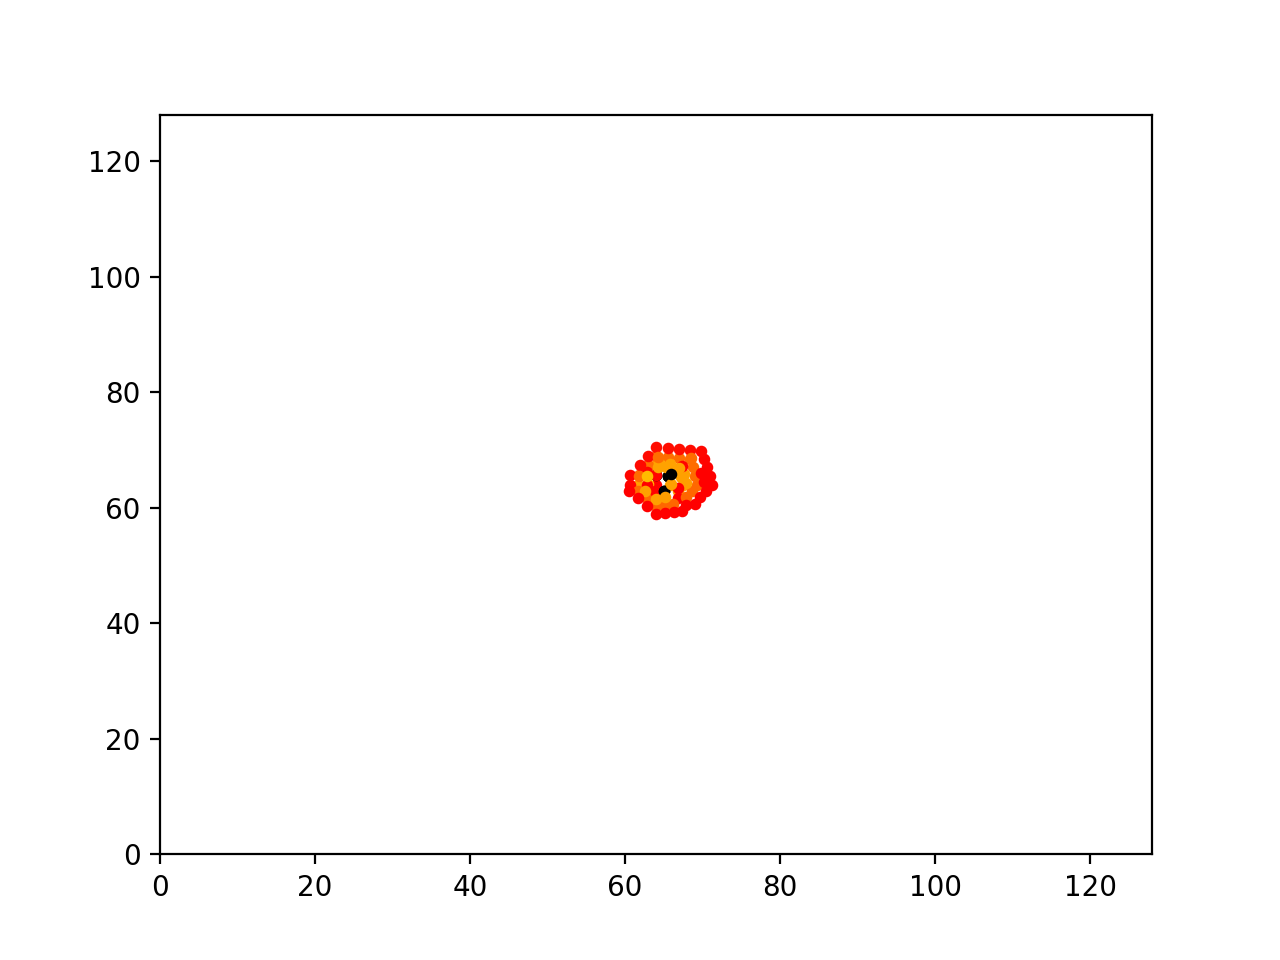

SEED:  97


In [9]:

SIZE = 128

SEED = np.random.randint(0, 1000)

FIRE_LST = [(64, 64)]

FOREST, WIND_DIRECTION, WIND_STRENGTH = initialize_grid(SIZE)


LST = [(1, 1), (1, 2), (2, 1), (2, 2), (4, 3), (10, 10)]

fig = plt.figure()


ani = animation.FuncAnimation(fig, animate, frames=1000, interval=500)

plt.show()
print("SEED: ", SEED)


Everything below is testing

Rewrite of above code because I made too many changes and it got too messy
